# Necessary Libraries


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt  
import io
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from google.colab import files 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
# from  matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
from sklearn.metrics import roc_curve, auc,accuracy_score
# Time and counters
from time import perf_counter

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Reading DataSet

In [3]:
#uploaded = files.upload()

In [4]:
#uploaded = files.upload()
dataPath   = "drive/MyDrive/Mahboob/Dataset/" 
heatmaps   = "drive/MyDrive/Mahboob/Heatmaps/"
Visuals    = "drive/MyDrive/Mahboob/Visuals/"
Comparison = "drive/MyDrive/Mahboob/Comparison/"
Model      = "drive/MyDrive/Mahboob/Models/"

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


def ROC_AUC(y_test, y_pred, fname):
    # evluate true positive rate and false positive rate using sklearn builtin function
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)

    # display auc score
    print("AUC:", lr_auc)
    # plot linear line with no learning
    plt.plot([0, 1], [0, 1], 'k--')
    # plot tpr and fpr ratio
    plt.plot(lr_fpr, lr_tpr, marker='.', label='lr (auc = %0.3f)' % lr_auc)
    # assign labels
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characterisics')
    plt.legend(loc='lower right')
    plt.savefig(f"{Visuals}{fname}")
    # plt.savefig(f"{fname}.jpeg")
    return lr_auc

def get_Metrics(y_test, y_pred, average="macro"):
    
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)
    precision = precision_score(y_test, y_pred, average = average)
    recall = recall_score(y_test, y_pred, average = average)
    f1_score_ = f1_score(y_test, y_pred, average = average)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
    return precision, recall, f1_score_, accuracy, lr_auc


In [5]:

data = pd.read_csv(f"{dataPath}spam(madeof).csv")
data.head()

,v1,v2
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [6]:
data["spam"] = data.v1
data["text"] = data.v2

# Splitting data

In [7]:
emails_train, emails_test, target_train, target_test = train_test_split(data.text, data.spam, test_size = 0.2) 

In [8]:
data.info

<bound method DataFrame.info of         v1  ...                                               text
0      ham  ...  Subject: enron methanol ; meter # : 988291\nth...
1      ham  ...  Subject: hpl nom for january 9 , 2001\r\n( see...
2      ham  ...  Subject: neon retreat\r\nho ho ho , we ' re ar...
3     spam  ...  Subject: photoshop , windows , office . cheap ...
4      ham  ...  Subject: re : indian springs\r\nthis deal is t...
...    ...  ...                                                ...
5166   ham  ...  Subject: put the 10 on the ft\r\nthe transport...
5167   ham  ...  Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168   ham  ...  Subject: calpine daily gas nomination\r\n>\r\n...
5169   ham  ...  Subject: industrial worksheets for august 2000...
5170  spam  ...  Subject: important online banking alert\r\ndea...

[5171 rows x 4 columns]>

In [9]:
emails_train.shape

(4136,)

In [10]:
data.describe()


,v1,v2,spam,text
count,5171,5171,5171,5171
unique,2,4993,2,4993
top,ham,Subject: calpine daily gas nomination\r\n>\r\n...,ham,Subject: calpine daily gas nomination\r\n>\r\n...
freq,3672,20,3672,20


In [11]:
data.corr()


""


# Preprocessing

In [12]:
def remove_hyperlink(word):
    return  re.sub(r'http\S+', '', word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

#x_train[0]

In [13]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [14]:
train_y


array([0, 0, 1, ..., 0, 0, 0])

# Tokenize

In [15]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [16]:
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

#x_train_features[0]

# Padding

In [17]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ...,  73,  48, 351], dtype=int32)

# Model

In [18]:
embedding_vecor_length = 32

#**LSTM** 

In [19]:
# LSTM
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(tf.keras.layers.LSTM(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,625,889
Trainable params: 1,625,889
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# LSTM
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=15, validation_split=0.2)
duration_lstm = perf_counter() - start
duration_lstm = round(duration_lstm,2)
lstm_history = history 

Epoch 1/15
7/7 [==============================] - 7s 240ms/step - loss: 0.6880 - accuracy: 0.6654 - val_loss: 0.6757 - val_accuracy: 0.6969
Epoch 2/15
7/7 [==============================] - 1s 179ms/step - loss: 0.6384 - accuracy: 0.7143 - val_loss: 0.5966 - val_accuracy: 0.6969
Epoch 3/15
7/7 [==============================] - 1s 177ms/step - loss: 0.5427 - accuracy: 0.7146 - val_loss: 0.5412 - val_accuracy: 0.6993
Epoch 4/15
7/7 [==============================] - 1s 177ms/step - loss: 0.4272 - accuracy: 0.7285 - val_loss: 0.6624 - val_accuracy: 0.7077
Epoch 5/15
7/7 [==============================] - 1s 177ms/step - loss: 0.4594 - accuracy: 0.9232 - val_loss: 0.3738 - val_accuracy: 0.8829
Epoch 6/15
7/7 [==============================] - 1s 176ms/step - loss: 0.2843 - accuracy: 0.9432 - val_loss: 0.2733 - val_accuracy: 0.8937
Epoch 7/15
7/7 [==============================] - 1s 176ms/step - loss: 0.1834 - accuracy: 0.9773 - val_loss: 0.1997 - val_accuracy: 0.9457
Epoch 8/15
7/7 [====

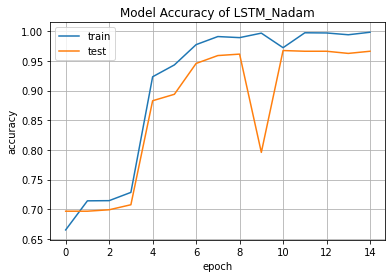

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of LSTM_Nadam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}LSTM-nadam-acc-loss.jpeg")

#Confusion Matrix

In [22]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [23]:
cf_matrix =confusion_matrix(test_y,y_predict)

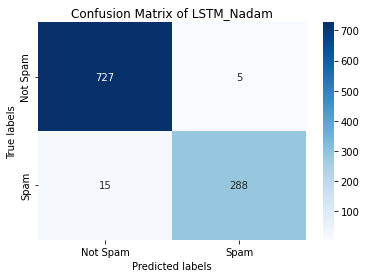

In [24]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of LSTM_Nadam')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam'])
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}LSTM-nadam-heatmap.jpeg")

In [25]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [26]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 98.29%
Recall: 95.05%
F1 Score: 96.64%


In [27]:
f1_score(test_y,y_predict)

0.9664429530201342

AUC: 0.9718322242060272


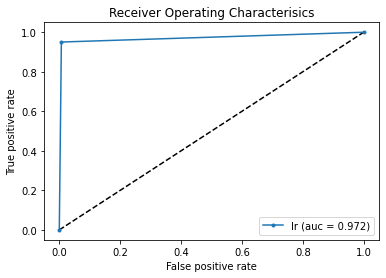

In [28]:
#AUC
auc_lstm = ROC_AUC(test_y, y_predict, "LSTM_nadam_AUC.jpeg")

In [29]:
lstm = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_lstm,
    "duration" : duration_lstm

}

In [30]:
!ls
model.save("drive/MyDrive/Mahboob/Models/LSTM_nadam.h5")

drive  sample_data


In [31]:
lstm

{'AUC': 0.9718322242060272,
 'duration': 24.03,
 'f1-score': 0.9664429530201342,
 'precision': 0.9829351535836177,
 'recall': 0.9504950495049505,
 'test-acc': 0.9806763285024155,
 'train-acc': 0.9981862306594849}

#**Bi-LSTM**

In [32]:
# Bilstm
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# BiLSTM
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_split=0.2)
duration_bi_lstm = perf_counter() - start
duration_bi_lstm = round(duration_bi_lstm,2)
bi_lstm_history = history 


Epoch 1/20
7/7 [==============================] - 6s 426ms/step - loss: 0.6601 - accuracy: 0.7143 - val_loss: 0.6133 - val_accuracy: 0.6969
Epoch 2/20
7/7 [==============================] - 2s 333ms/step - loss: 0.6231 - accuracy: 0.7143 - val_loss: 0.5301 - val_accuracy: 0.6969
Epoch 3/20
7/7 [==============================] - 2s 334ms/step - loss: 0.5178 - accuracy: 0.7146 - val_loss: 0.4647 - val_accuracy: 0.6981
Epoch 4/20
7/7 [==============================] - 2s 337ms/step - loss: 0.3692 - accuracy: 0.7494 - val_loss: 0.3462 - val_accuracy: 0.8128
Epoch 5/20
7/7 [==============================] - 2s 334ms/step - loss: 0.3668 - accuracy: 0.9308 - val_loss: 0.3326 - val_accuracy: 0.8949
Epoch 6/20
7/7 [==============================] - 2s 336ms/step - loss: 0.2486 - accuracy: 0.9686 - val_loss: 0.2585 - val_accuracy: 0.9118
Epoch 7/20
7/7 [==============================] - 2s 335ms/step - loss: 0.1715 - accuracy: 0.9858 - val_loss: 0.1835 - val_accuracy: 0.9577
Epoch 8/20
7/7 [====

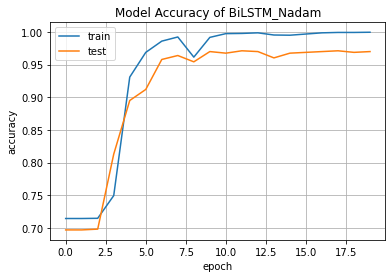

<Figure size 432x288 with 0 Axes>

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of BiLSTM_Nadam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}Bi-LSTM-nadam-acc-loss.jpeg")

#Confusion Matrix BiLSTM


In [35]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [36]:
cf_matrix =confusion_matrix(test_y,y_predict)

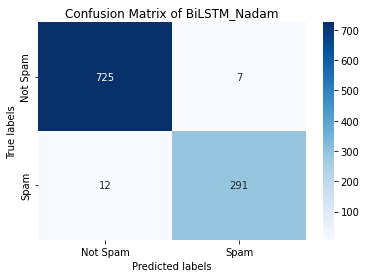

In [37]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of BiLSTM_Nadam') 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']) 
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}Bi-LSTM-nadam-heatmap.jpeg")

In [38]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [39]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 97.65%
Recall: 96.04%
F1 Score: 96.84%


In [40]:
f1_score(test_y,y_predict)

0.9683860232945091

AUC: 0.9754165990369529


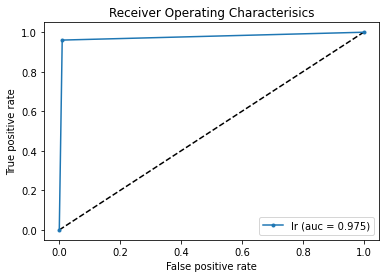

In [41]:
#AUC
auc_bi_lstm = ROC_AUC(test_y, y_predict, "Bi-LSTM-nadam_AUC.jpeg")

In [42]:
Bi_lstm = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_bi_lstm,
    "duration" : duration_bi_lstm

}

In [43]:
!ls
model.save("drive/MyDrive/Mahboob/Models/Bi_LSTM-nadam.h5")

drive  sample_data


In [44]:
Bi_lstm

{'AUC': 0.9754165990369529,
 'duration': 49.98,
 'f1-score': 0.9683860232945091,
 'precision': 0.9765100671140939,
 'recall': 0.9603960396039604,
 'test-acc': 0.9816425120772947,
 'train-acc': 0.9993954300880432}

#**GRU**

In [45]:
#GRU
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
# model.add(GRU(units=64, dropout=0.1,recurrent_dropout=0.1))
model.add(tf.keras.layers.GRU(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,619,873
Trainable params: 1,619,873
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# GRU
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=15, validation_split=0.2)
duration_gru = perf_counter() - start
duration_gru = round(duration_gru,2)
gru_history = history 

Epoch 1/15
7/7 [==============================] - 3s 229ms/step - loss: 0.6809 - accuracy: 0.7025 - val_loss: 0.6634 - val_accuracy: 0.6969
Epoch 2/15
7/7 [==============================] - 1s 180ms/step - loss: 0.6362 - accuracy: 0.7143 - val_loss: 0.5939 - val_accuracy: 0.6969
Epoch 3/15
7/7 [==============================] - 1s 180ms/step - loss: 0.5282 - accuracy: 0.7149 - val_loss: 0.4709 - val_accuracy: 0.7005
Epoch 4/15
7/7 [==============================] - 1s 181ms/step - loss: 0.5050 - accuracy: 0.7579 - val_loss: 0.3861 - val_accuracy: 0.7705
Epoch 5/15
7/7 [==============================] - 1s 181ms/step - loss: 0.2942 - accuracy: 0.8482 - val_loss: 0.3069 - val_accuracy: 0.8164
Epoch 6/15
7/7 [==============================] - 1s 181ms/step - loss: 0.2156 - accuracy: 0.9338 - val_loss: 0.2639 - val_accuracy: 0.8671
Epoch 7/15
7/7 [==============================] - 1s 181ms/step - loss: 0.1685 - accuracy: 0.9755 - val_loss: 0.2200 - val_accuracy: 0.9094
Epoch 8/15
7/7 [====

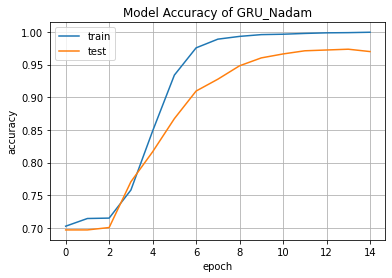

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of GRU_Nadam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}gru-nadam-acc-loss.jpeg")

#Confusion Matrix GRU


In [48]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [49]:
cf_matrix =confusion_matrix(test_y,y_predict)

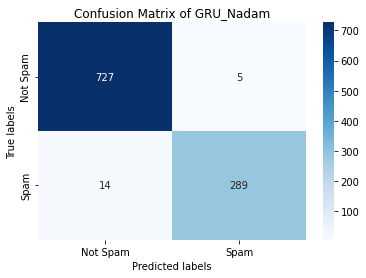

In [50]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of GRU_Nadam') 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']) 
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}gru-nadam-heatmap.jpeg")

In [51]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [52]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 98.30%
Recall: 95.38%
F1 Score: 96.82%


In [53]:
f1_score(test_y,y_predict)

0.9681742043551089

AUC: 0.9734823892225289


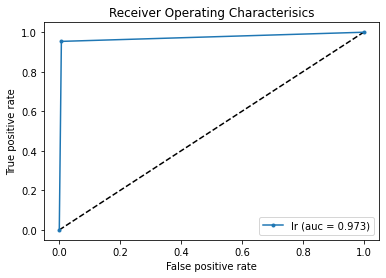

In [54]:
#AUC
auc_gru = ROC_AUC(test_y, y_predict, "gru_nadam_AUC.jpeg")

In [55]:
gru = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_gru,
    "duration" : duration_gru

}

In [56]:
!ls
model.save("drive/MyDrive/Mahboob/Models/GRU_nadam.h5")

drive  sample_data


In [57]:
gru

{'AUC': 0.9734823892225289,
 'duration': 20.86,
 'f1-score': 0.9681742043551089,
 'precision': 0.9829931972789115,
 'recall': 0.9537953795379538,
 'test-acc': 0.9816425120772947,
 'train-acc': 0.9993954300880432}

In [58]:
models_metrics = []
Nadam = {
    "lstm-nadam" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    },
    "Bi_lstm-nadam" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    },
    "gru-nadam" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    }
}
for (l,b,g) in zip(lstm,Bi_lstm,gru):
  Nadam["lstm-nadam"][l] = lstm[l]
  Nadam["Bi_lstm-nadam"][b] = Bi_lstm[b]
  Nadam["gru-nadam"][g] = gru[g]   

Nadam 



{'Bi_lstm-nadam': {'AUC': 0.9754165990369529,
  'duration': 49.98,
  'f1-score': 0.9683860232945091,
  'precision': 0.9765100671140939,
  'recall': 0.9603960396039604,
  'test-acc': 0.9816425120772947,
  'train-acc': 0.9993954300880432},
 'gru-nadam': {'AUC': 0.9734823892225289,
  'duration': 20.86,
  'f1-score': 0.9681742043551089,
  'precision': 0.9829931972789115,
  'recall': 0.9537953795379538,
  'test-acc': 0.9816425120772947,
  'train-acc': 0.9993954300880432},
 'lstm-nadam': {'AUC': 0.9718322242060272,
  'duration': 24.03,
  'f1-score': 0.9664429530201342,
  'precision': 0.9829351535836177,
  'recall': 0.9504950495049505,
  'test-acc': 0.9806763285024155,
  'train-acc': 0.9981862306594849}}

In [59]:
models_metrics= []
for name, model in Nadam.items():
  # print(name,model)
  #print(model["y_pred"].shape)
  precision, recall, f1_score_,  = model["precision"], model["recall"], model["f1-score"]
  accuracy, lr_auc = model["test-acc"], model["AUC"]
  Train_acc, duration = model["train-acc"], model["duration"]
  #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
  models_metrics.append([name, precision, recall, f1_score_, Train_acc, accuracy, lr_auc, duration])

df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', "Train Accuracy", 'Test Accuracy', 'ROC-AUC', 'Train Time (s)']
df_metrics.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
df_metrics.to_csv(f"{Comparison}Nadam_comparison.csv") 

In [60]:
df_metrics

,Model,Precision,Recall,f1 score,Train Accuracy,Test Accuracy,ROC-AUC,Train Time (s)
0,Bi_lstm-nadam,0.976510,0.960396,0.968386,0.999395,0.981643,0.975417,49.98
1,gru-nadam,0.982993,0.953795,0.968174,0.999395,0.981643,0.973482,20.86
2,lstm-nadam,0.982935,0.950495,0.966443,0.998186,0.980676,0.971832,24.03
